In [1]:
import corner
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tftables
import time

import data_loader
import model_short as model
import toy_data_loader

%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
np.set_printoptions(suppress=True, precision=3)

In [3]:
class hps:
    pass
hps.n_levels = 3 # number of splits
hps.depth = 1 # number of layers in revnet
hps.width = 8 # channels in revnet layers
hps.polyak_epochs = 1
hps.beta1 = .9 # learning rate annealing factor
hps.weight_decay = 1 # learning rate annealing factor
hps.lr = .001 # base learning rate
hps.n_data = 800 # number of input spectra
hps.batch_size = 5 # number of spectra in a batch
hps.n_batches = int(hps.n_data / hps.batch_size)
hps.n_bins = 2**7

In [4]:
sess = tf.InteractiveSession()

In [5]:
# select real or toy data by uncommenting the appropriate line
# real data must have n_data=8000, n_bins=40000
#input_stream, initialize_input_stream, data_init = data_loader.create_data_loader(
input_stream, initialize_input_stream, data_init = toy_data_loader.create_data_loader(
    sess, hps.batch_size, hps.n_data, hps.n_bins
)

W0204 12:06:06.494624 139952347817728 deprecation.py:323] From /home/tey/glow/toy_data_loader.py:35: DatasetV1.make_initializable_iterator (from tensorflow.python.data.ops.dataset_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use `for ... in dataset:` to iterate over a dataset. If using `tf.estimator`, return the `Dataset` object directly from your input function. As a last resort, you can use `tf.compat.v1.data.make_initializable_iterator(dataset)`.


(5, 128, 1)


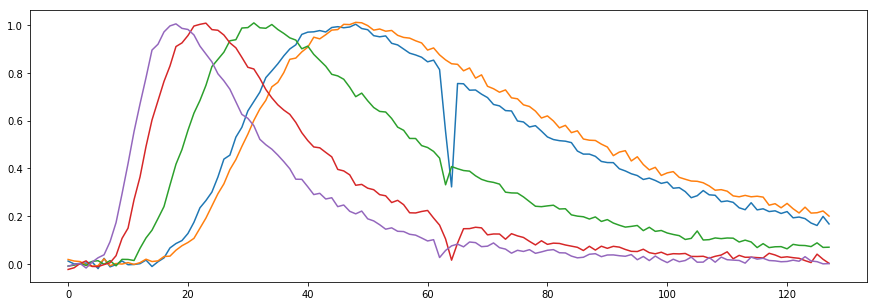

In [6]:
print(data_init.shape)
plt.figure(figsize=(15, 5))
for spectrum in data_init[:5]:
    plt.plot(spectrum)

In [7]:
with tf.device("/device:GPU:0"):
    m = model.model(sess, hps, input_stream, data_init)

W0202 16:06:33.690433 140124142556928 deprecation.py:506] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/ops/init_ops.py:1251: calling VarianceScaling.__init__ (from tensorflow.python.ops.init_ops) with dtype is deprecated and will be removed in a future version.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
W0202 16:06:33.751603 140124142556928 deprecation_wrapper.py:119] From /home/tey/glow/tfops_short.py:102: The name tf.get_variable is deprecated. Please use tf.compat.v1.get_variable instead.



original shape (?, 8192, 1)
encoding z (?, 2048, 4)
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
calculating prior (?, 128, 4)


W0202 16:06:39.423533 140124142556928 deprecation.py:323] From /home/tey/env/lib/python3.5/site-packages/tensorflow/python/training/moving_averages.py:433: Variable.initialized_value (from tensorflow.python.ops.variables) is deprecated and will be removed in a future version.
Instructions for updating:
Use Variable.read_value. Variables in 2.X are initialized automatically both in eager and graph (inside tf.defun) contexts.


original shape (?, 8192, 1)
encoding z (?, 2048, 4)
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
calculating prior (?, 128, 4)


In [8]:
%%time
m.train(.001)

CPU times: user 4.71 s, sys: 32 ms, total: 4.74 s
Wall time: 4.72 s


array([-1.24], dtype=float32)

In [10]:
n_processed = 0

hps.epochs = 20
hps.epochs_warmup = 5
hps.print_freq = 10

for epoch in range(1, hps.epochs + 1):
    train_results = []
    initialize_input_stream()
    epoch_start_time = time.time()
    for iteration in range(hps.n_batches):
        lr = hps.lr * min(1., n_processed / (hps.batch_size * hps.n_batches * hps.epochs_warmup))
        start_time = time.time()
        train_results += [m.train(lr)]
        n_processed += hps.batch_size
        #if epoch == 1 and iteration % hps.print_freq == 0:
            #print(epoch, iteration, np.round(time.time() - start_time, 3), train_results[-1][0])
    print(epoch, np.round(time.time() - epoch_start_time, 3), np.round(np.mean(train_results, axis=0), 3))

1 2.469 [3.426]
2 1.475 [2.378]
3 1.455 [1.041]
4 1.458 [-0.08]
5 1.652 [-1.285]
6 1.471 [-2.138]
7 1.752 [-2.401]
8 1.639 [-2.532]
9 1.71 [-2.632]
10 1.429 [-2.71]
11 1.51 [-2.773]
12 1.668 [-2.823]
13 1.595 [-2.863]
14 1.51 [-2.897]
15 1.734 [-2.926]
16 1.73 [-2.952]
17 1.497 [-2.975]
18 1.557 [-2.996]
19 1.463 [-3.016]
20 1.696 [-3.034]
21 1.594 [-3.05]
22 1.49 [-3.066]
23 1.454 [-3.08]
24 1.484 [-3.093]
25 1.472 [-3.105]
26 1.55 [-3.116]
27 1.656 [-3.127]
28 1.592 [-3.137]
29 1.469 [-3.147]
30 1.532 [-3.156]
31 1.587 [-3.164]
32 1.53 [-3.173]
33 1.541 [-3.181]
34 1.684 [-3.188]
35 1.453 [-3.196]
36 1.607 [-3.203]
37 1.515 [-3.209]
38 1.656 [-3.216]
39 1.507 [-3.222]
40 1.685 [-3.228]
41 1.545 [-3.235]
42 1.531 [-3.241]
43 1.602 [-3.247]
44 1.446 [-3.252]
45 1.413 [-3.258]
46 1.66 [-3.264]
47 1.568 [-3.27]
48 1.512 [-3.275]
49 1.51 [-3.281]
50 1.589 [-3.286]


In [12]:
i = np.random.randint(0, hps.batch_size)
spectrum = data_init[i, :, :]
print(i)

21


In [13]:
latent_rep = m.encode(spectrum)
spectrum = m.decode(latent_rep)

W0202 16:11:45.831241 140124142556928 deprecation_wrapper.py:119] From /home/tey/glow/model_short.py:119: The name tf.variable_scope is deprecated. Please use tf.compat.v1.variable_scope instead.



creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1

W0202 16:11:48.209688 140124142556928 deprecation_wrapper.py:119] From /home/tey/glow/model_short.py:217: The name tf.matrix_inverse is deprecated. Please use tf.linalg.inv instead.



actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048


In [14]:
print(latent_rep.mean(), latent_rep.std())

0.091311365 0.8771767


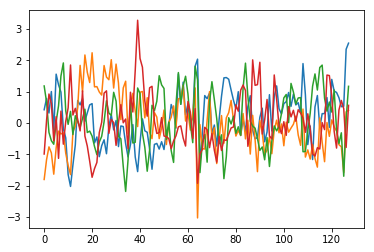

In [15]:
plt.plot(latent_rep[0, :, 0])
plt.plot(latent_rep[0, :, 1])
plt.plot(latent_rep[0, :, 2])
plt.plot(latent_rep[0, :, 3])

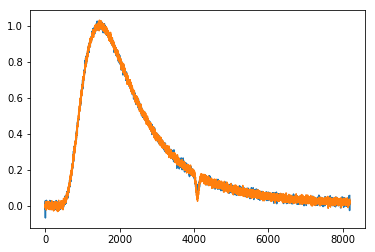

In [16]:
plt.plot(np.squeeze(spectrum))
plt.plot(np.squeeze(sample_data))

(3276.8, 4915.2)

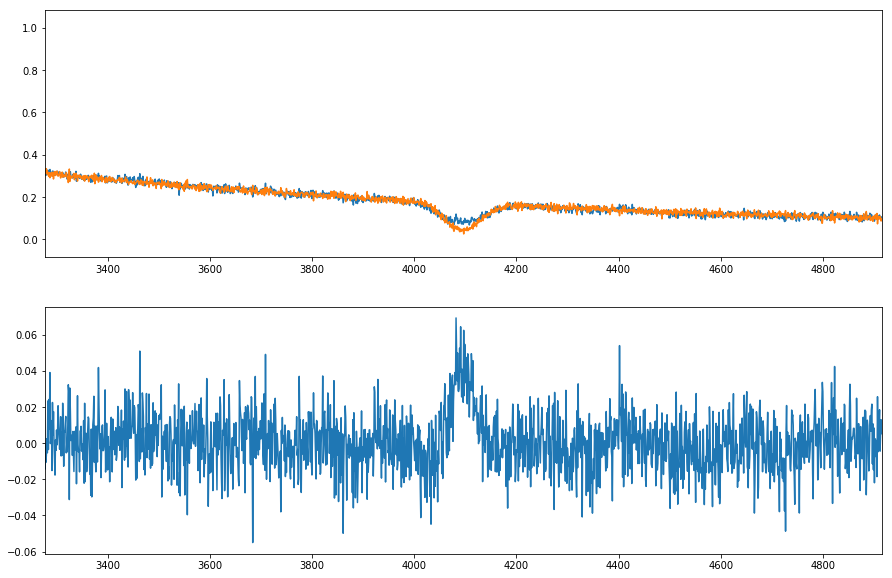

In [17]:
plt.figure(figsize=(15, 10))

plt.subplot(2, 1, 1)
plt.plot(np.squeeze(np.clip(spectrum, 0, 1)))
plt.plot(np.squeeze(sample_data))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.4, hps.n_bins*.6)

plt.subplot(2, 1, 2)
plt.plot(np.squeeze(np.clip(spectrum, 0, 1)) - np.squeeze(sample_data))
#plt.xlim(12000, 14000)
plt.xlim(hps.n_bins*.4, hps.n_bins*.6)

In [18]:
# Make a corner plot with 4 components of the latent representation
latent_reps = np.empty([0, 4])
initialize_input_stream()
for _ in range(hps.n_batches):
    data = sess.run(input_stream)
    latent_rep = sess.run(m.encode(m.X), feed_dict={m.X: data})
    latent_reps = np.append(latent_reps, latent_rep[:, 0, :], axis=0) # append to list of latent representations

creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1

actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)

actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_

creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1,

actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)

actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_

creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1,

actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)

actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_

creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1,

actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)

actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_

actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 

actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)

actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_

creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1,

actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)

actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
actnorm_scale (?, 256, 4) (1, 1, 4) 256
splitting z (?, 256, 4)
creating revnet level 4 (?, 128, 4)
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
actnorm_scale (?, 128, 4) (1, 1, 4) 128
creating revnet level 0 (?, 2048, 4)
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
actnorm_scale (?, 2048, 4) (1, 1, 4) 2048
splitting z (?, 2048, 4)
creating revnet level 1 (?, 1024, 4)
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
actnorm_scale (?, 1024, 4) (1, 1, 4) 1024
splitting z (?, 1024, 4)
creating revnet level 2 (?, 512, 4)
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
actnorm_scale (?, 512, 4) (1, 1, 4) 512
splitting z (?, 512, 4)
creating revnet level 3 (?, 256, 4)
actnorm_

In [22]:
print(latent_reps.shape, latent_reps.mean(axis=0), latent_reps.std(axis=0))

(4000, 4) [ 1.46  -1.579  0.164 -0.03 ] [0.734 0.527 1.046 0.748]


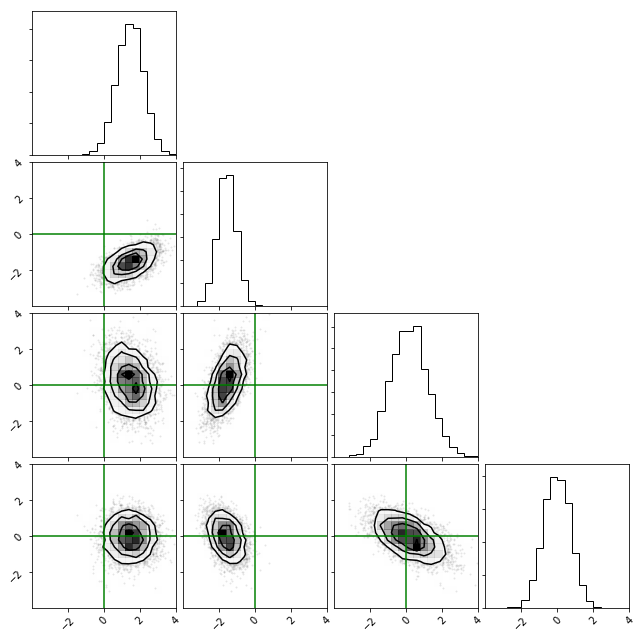

In [42]:
figure = corner.corner(latent_reps, range=4*[(-4, 4)])

axes = np.array(figure.axes).reshape((4, 4))
for yi in range(4):
    for xi in range(yi):
        ax = axes[yi, xi]
        ax.axvline(0, color="g")
        ax.axhline(0, color="g")